In [274]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [275]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

import scipy.io
basins = scipy.io.loadmat('../data/shapefiles/bsn_boundary.mat', simplify_cells=True, squeeze_me=True)['bsn_only']

In [297]:
import sys
sys.path.append("../")
import regionate as reg
import sectionate as sec

In [298]:
basins_dict = {
    str(basin['bsn_num'].replace("_", "")):
    reg.Basin(basin['bsn'][0], basin['bsn'][1], str(basin['bsn_num'].replace("_", "")))
    for basin in basins
}
region = reg.Region(basins_dict)
region.find_all_overlaps()
region.align_boundaries_with_overlap_sections()
region.find_all_overlaps()

### Add two new LAND regions (for accurate global accounting)

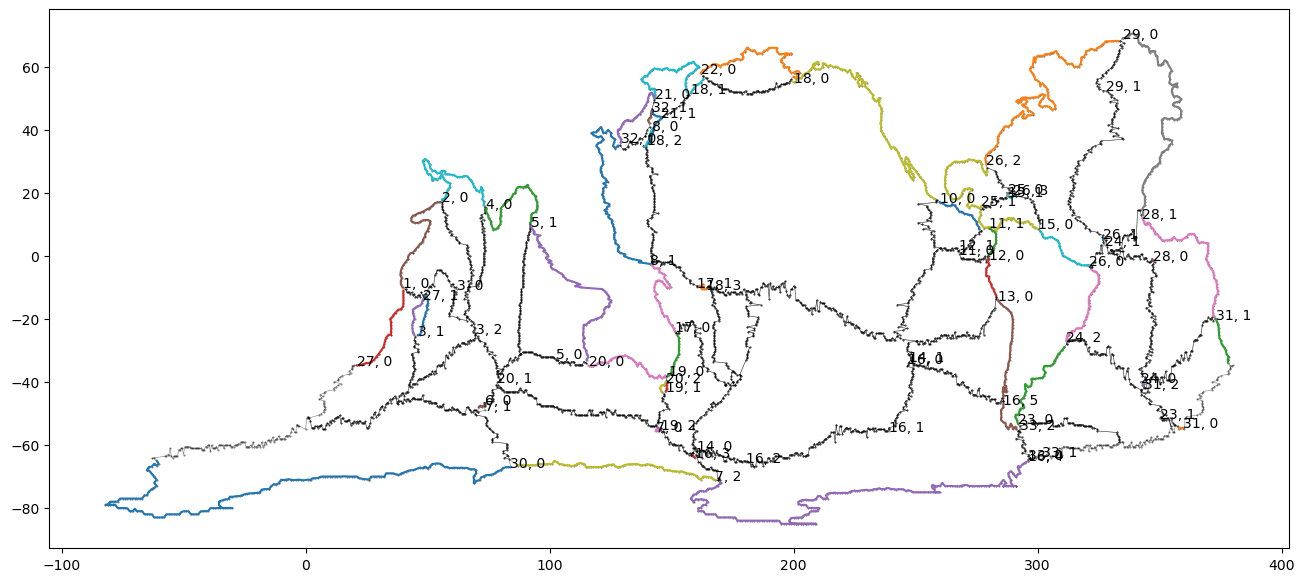

In [299]:
non_overlaps_dict = {}
plt.figure(figsize=(16, 7))
for b in region.Basins.values():
    plt.plot(np.append(b.lons, b.lons[0]), np.append(b.lats, b.lats[0]), "k.-", alpha=0.5, lw=0.4, markersize=1)
    
    overlap_list = [o for o in list(region.overlaps) if b.name in o]
    all_overlaps = np.unique([ooo for o in overlap_list for (onum, oo) in region.overlaps[o][b.name].items() for ooo in oo])
    non_overlaps = np.array([i for i in range(b.lons.size) if i not in all_overlaps])
    non_overlaps = reg.split_non_consecutive_list(non_overlaps, mod=b.lons.size)
    for i, no in enumerate(non_overlaps):
        non_overlaps_dict[(b.name, i)] = np.append(no[::-1], no[0]-1)
        plt.plot(b.lons[no], b.lats[no])
        plt.annotate(f"{b.name}, {i}", xy=(b.lons[no[-1]], b.lats[no[-1]]), xytext=(b.lons[no[-1]], b.lats[no[-1]]), textcoords="data")

In [300]:
# Add Southern Hemisphere Continent
SH_continent_non_overlaps = [
    ['16', 4], ['7', 2], ['30', 0]
]
bname = '34'

lons = np.array([])
lats = np.array([])
for s in SH_continent_non_overlaps:
    lons = np.append(lons, region.Basins[s[0]].lons[non_overlaps_dict[(s[0], s[1])]])
    lats = np.append(lats, region.Basins[s[0]].lats[non_overlaps_dict[(s[0], s[1])]])
    
b = region.Basins[bname] = reg.Basin(lons, lats, bname)

In [301]:
# Add Northern Hemisphere Continent
NH_continent_non_overlaps = [
    ['27', 0], ['1', 0], ['2', 0], ['4', 0], ['5', 1], ['20', 0], ['19', 0], ['17', 0], ['8', 1], ['32', 0], ['21', 0], ['18', 1], ['22', 0], ['18', 0],
    ['10', 0], ['11', 1], ['12', 0], ['13', 0], ['16', 5], ['23', 0], ['24', 2], ['26', 0], ['15', 0], ['25', 1], ['26', 2], ['29', 0], ['28', 1], ['31', 1]
]
bname = '35'

lons = np.array([])
lats = np.array([])
for s in NH_continent_non_overlaps:
    lons = np.append(lons, region.Basins[s[0]].lons[non_overlaps_dict[(s[0], s[1])]])
    lats = np.append(lats, region.Basins[s[0]].lats[non_overlaps_dict[(s[0], s[1])]])
    
b = region.Basins[bname] = reg.Basin(lons, lats, bname)

In [302]:
region.find_all_overlaps()
region.align_boundaries_with_overlap_sections()
region.find_all_overlaps()

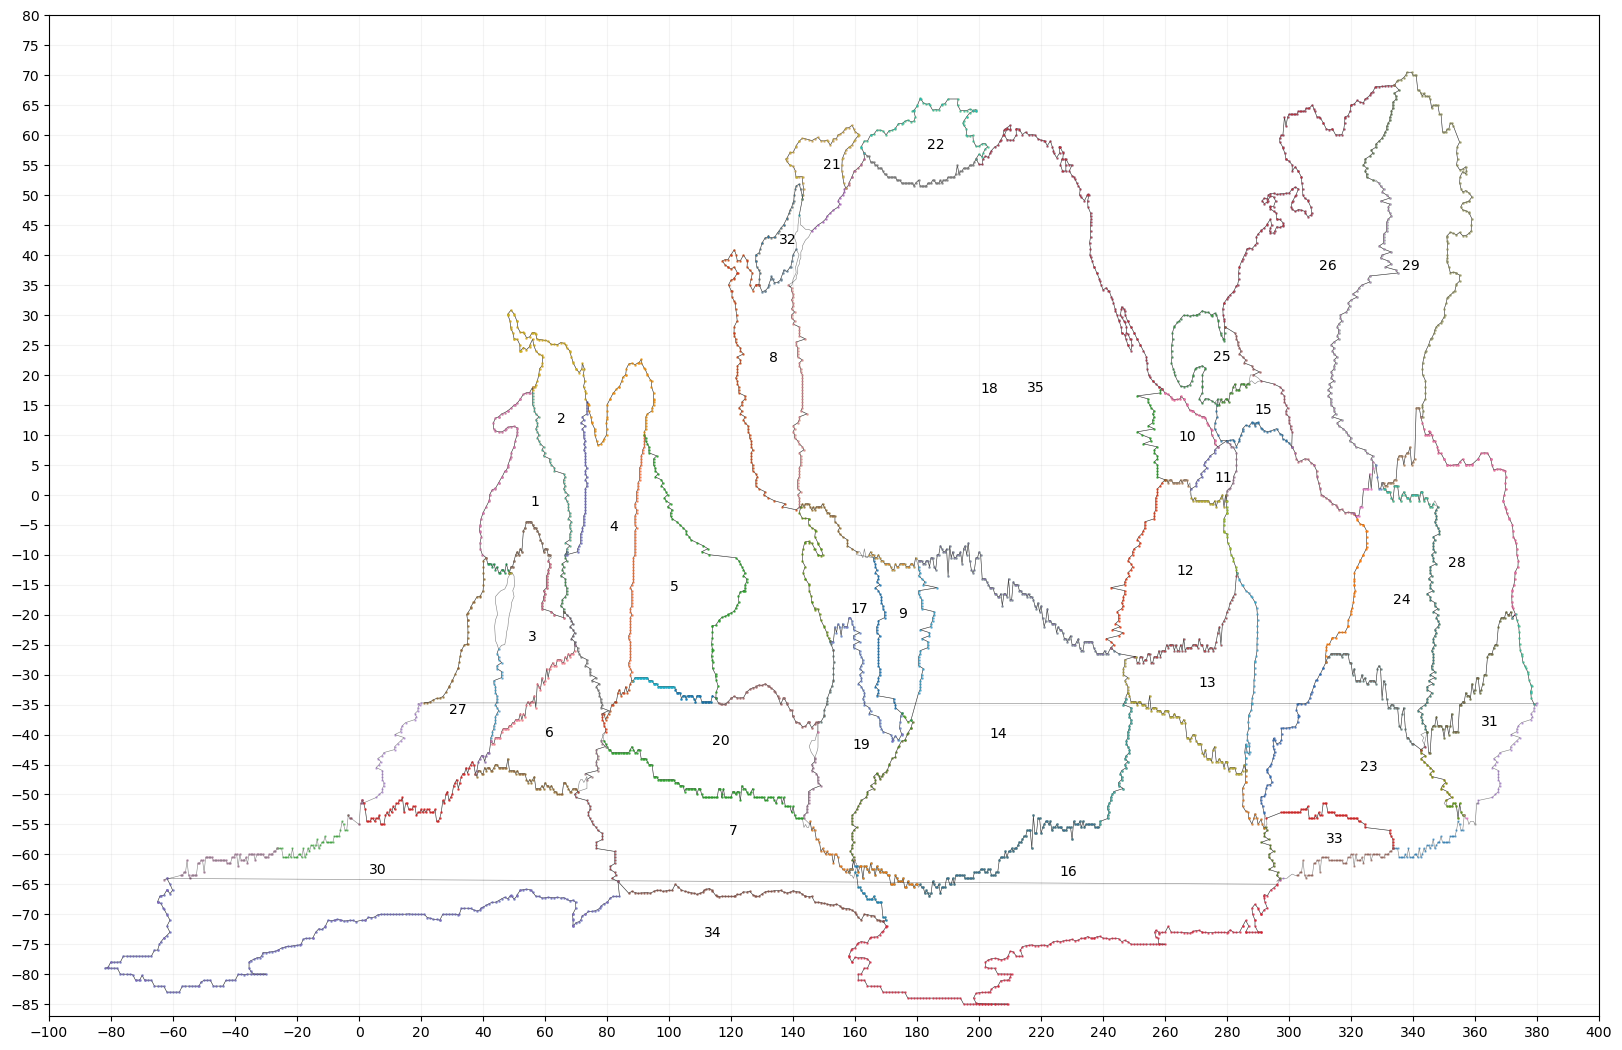

In [303]:
plt.figure(figsize=(20, 13))
for i, (bname, b) in enumerate(region.Basins.items()):
    plt.plot(
        np.append(b.lons, b.lons[0]),
        np.append(b.lats, b.lats[0]),
        alpha=0.5, lw=0.4, color="k"
    )
    
    plt.annotate(b.name, xy=(np.mean(b.lons), np.mean(b.lats)), xytext=(np.mean(b.lons), np.mean(b.lats)), textcoords="data")
    for (b1name, b2name), o in region.overlaps.items():
        if bname not in (b1name, b2name): continue
        for oo in o[bname].values():
            plt.plot(region.Basins[bname].lons[oo], region.Basins[bname].lats[oo], ".", alpha=0.5, markersize=1.5, lw=1)

plt.xlim(-100, 400)
plt.ylim(-87, 80);

plt.yticks(np.arange(-85, 85, 5))
plt.xticks(np.arange(-100, 410, 20))
plt.grid(True, alpha=0.15)

### Remove points that are neither part of an overlap nor a large non-overlap region like Madagascar, Tasmania, etc.

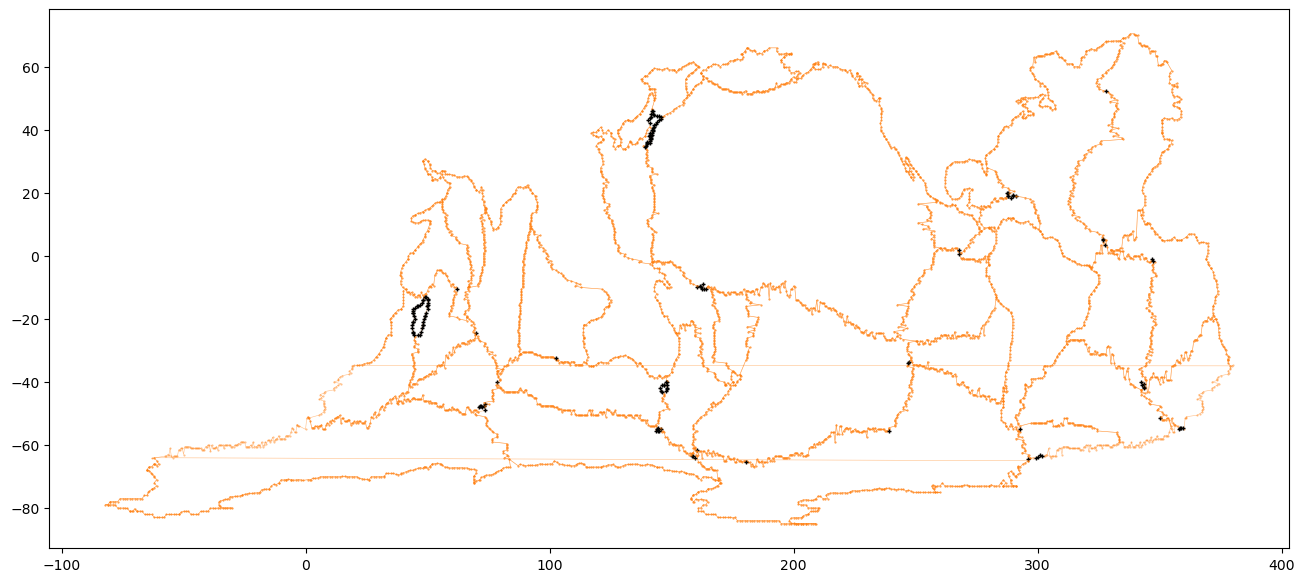

In [304]:
new_region = region.copy(remove_duplicate_points=False)

plt.figure(figsize=(16, 7))
for b in region.Basins.values():
    plt.plot(np.append(b.lons, b.lons[0]), np.append(b.lats, b.lats[0]), "C1.-", alpha=0.5, lw=0.4, markersize=1)
    
    overlap_list = [o for o in list(region.overlaps) if b.name in o]
    all_overlaps = np.unique([ooo for o in overlap_list for (onum, oo) in region.overlaps[o][b.name].items() for ooo in oo])
    non_overlaps = np.array([i for i in range(b.lons.size) if i not in all_overlaps])
    non_overlaps = reg.split_non_consecutive_list(non_overlaps, mod=b.lons.size)
    
    for i, no in enumerate(non_overlaps):
        plt.plot(b.lons[no], b.lats[no], "k+", markersize=3)
        new_region.Basins[b.name].lons[no] = np.nan
        new_region.Basins[b.name].lats[no] = np.nan
            
region = new_region.copy(remove_duplicate_points=False)

region.find_all_overlaps()
region.align_boundaries_with_overlap_sections()
region.find_all_overlaps()

In [ ]:
plt.figure(figsize=(20, 13))
for i, (bname, b) in enumerate(region.Basins.items()):
    plt.plot(
        np.append(b.lons, b.lons[0]),
        np.append(b.lats, b.lats[0]),
        alpha=0.5, lw=0.4, color="k"
    )
    
    plt.annotate(b.name, xy=(np.mean(b.lons), np.mean(b.lats)), xytext=(np.mean(b.lons), np.mean(b.lats)), textcoords="data")
    for (b1name, b2name), o in region.overlaps.items():
        if bname not in (b1name, b2name): continue
        for oo in o[bname].values():
            plt.plot(region.Basins[bname].lons[oo], region.Basins[bname].lats[oo], ".", alpha=0.5, markersize=1.5, lw=1)

plt.yticks(np.arange(-85, 85, 5))
plt.xticks(np.arange(-100, 410, 20))
plt.xlim(-100, 400)
plt.ylim(-87, 80);
plt.grid(True, alpha=0.15)

### Clean-up a few intersections
[1,2,4] - 200km

[30, 27, 31, 23] - 200km

[7, 16, 14, 19] - 300km

[4,6,20] - 250km

[6, 7, 20] - 250k

[8, 18, 17] - 150km

[25, 15, 35] - 200km

[11, 12, 35] - 200km

[35, 33, 23, 16] - 300km

[26, 29, 24] - 250km

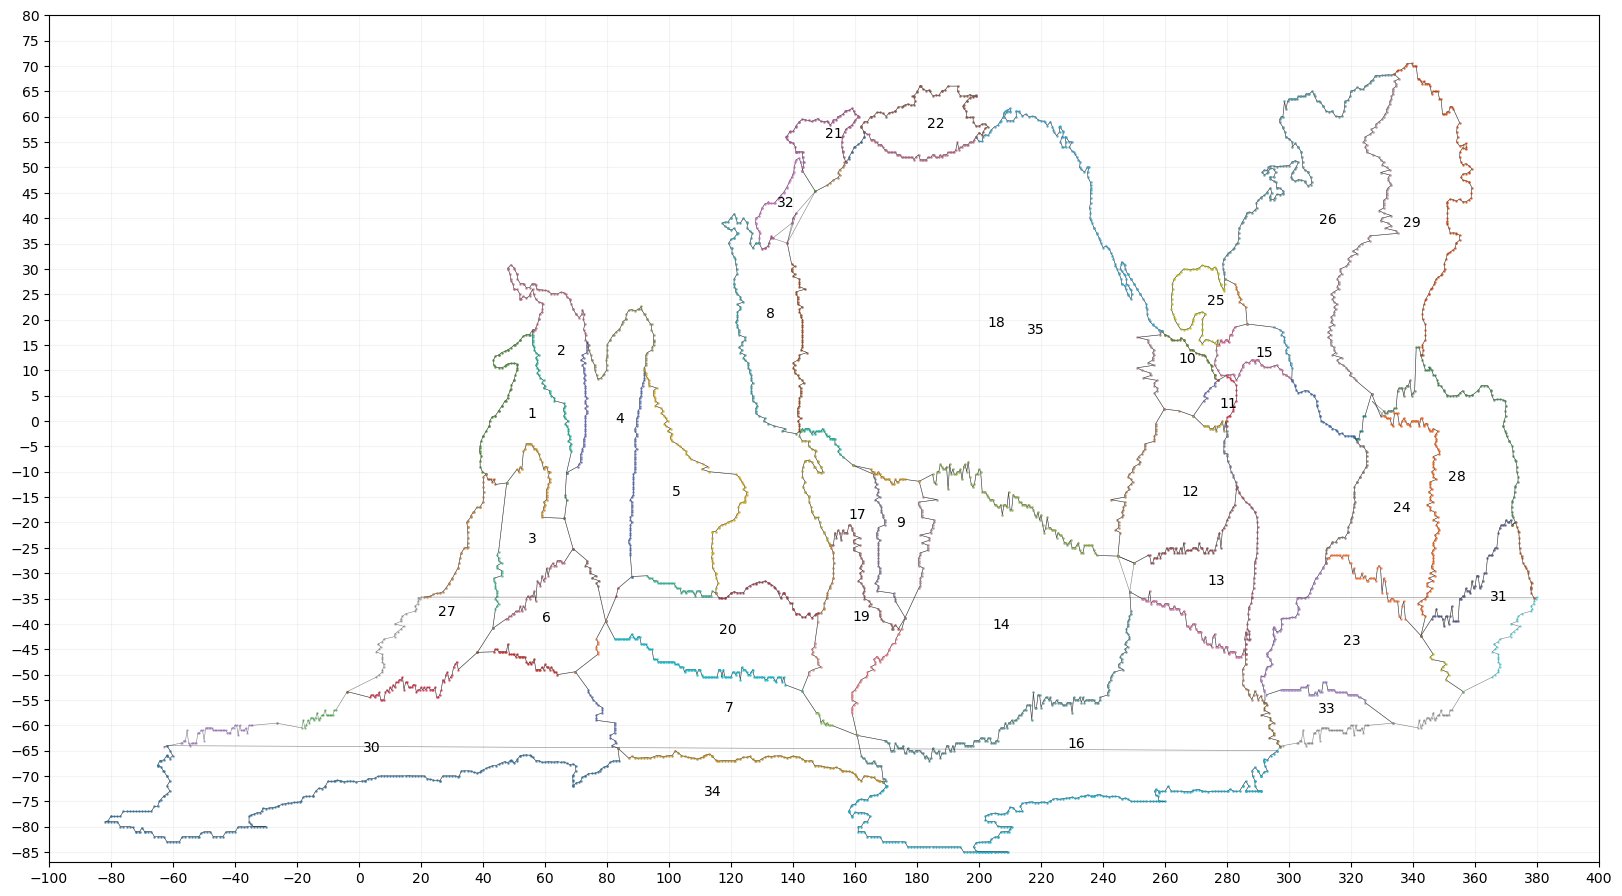

In [294]:
new_region = region.copy()

# For each overlap end point, find points in any nearby basin within a certain radius ~(200 km).
closeness_threshold = 1.e3
endpoint_radius = 450.e3

used_overlaps = []
for (b1name, b2name), o in region.overlaps.items():
    b1 = region.Basins[b1name]
    b2 = region.Basins[b2name]
    
    olist1 = reg.unique_list([oname for o in list(region.overlaps) if b1name in o for oname in o])
    olist2 = reg.unique_list([oname for o in list(region.overlaps) if b2name in o for oname in o])
    blist = [
        bname for bname in region.Basins.keys()
        if ((bname in olist1) or (bname in olist2))
    ]
    
    for n in range(len(o[b1name])):
        for i in [0, -1]:
            idx = o[b1name][n][i]
            lon = b1.lons[idx]
            lat = b1.lats[idx]
    
            nearby_lons = np.array([])
            nearby_lats = np.array([])
            
            overlapping_basins = []
            for bname in blist:
                b = region.Basins[bname]
                endpoint_dist = reg.haversine(
                    lon, lat,
                    b.lons, b.lats
                )
                
                near_endpoint = endpoint_dist < endpoint_radius
                if np.any(near_endpoint):
                    nearby_lons = np.append(nearby_lons, b.lons[near_endpoint])
                    nearby_lats = np.append(nearby_lats, b.lats[near_endpoint])
                    overlapping_basins.append(bname)
            
            # Don't do anything if nearby one of the land regions!
            if len([name for name in ['34', '35'] if name in overlapping_basins]) > 0: continue
            
            unique_nearby_lons, unique_nearby_lats = reg.unique_lonlat(nearby_lons, nearby_lats)
            
            if (len(overlapping_basins)>=3 and (overlapping_basins not in used_overlaps) and
                not(np.any([o for o in used_overlaps if o in list(itertools.permutations(overlapping_basins, 3))]))):
                for bname in blist:
                    b = region.Basins[bname]
                    endpoint_dist = reg.haversine(
                        lon, lat,
                        b.lons, b.lats
                    )
                    near_endpoint = (endpoint_dist < endpoint_radius)

                    new_b = new_region.Basins[bname]

                    if np.any(near_endpoint):
                        idx = np.argmin(endpoint_dist)

                        new_b.lons[near_endpoint] = np.nan
                        new_b.lats[near_endpoint] = np.nan
                        
                        new_b.lons[idx] = reg.lon_mod(np.mean(reg.lon_mod(unique_nearby_lons, b.lons[idx])), b.lons[idx])
                        new_b.lats[idx] = np.mean(unique_nearby_lats)
            used_overlaps.append(overlapping_basins)
                
for (bname, b) in new_region.Basins.items():
    nan_idx = np.isnan(b.lons) | np.isnan(b.lats)
    b.lons = b.lons[~nan_idx]
    b.lats = b.lats[~nan_idx]
    
region = new_region.copy()
region.find_all_overlaps()


plt.figure(figsize=(20, 11))
for i, (bname, b) in enumerate(region.Basins.items()):
    plt.plot(
        np.append(b.lons, b.lons[0]),
        np.append(b.lats, b.lats[0]),
        alpha=0.5, lw=0.4, color="k"
    )
    
    plt.annotate(b.name, xy=(np.mean(b.lons), np.mean(b.lats)), xytext=(np.mean(b.lons), np.mean(b.lats)), textcoords="data")
    for (b1name, b2name), o in region.overlaps.items():
        if bname not in (b1name, b2name): continue
        for oo in o[bname].values():
            plt.plot(region.Basins[bname].lons[oo], region.Basins[bname].lats[oo], ".", alpha=0.5, markersize=1.5, lw=1)
        
plt.xlim(-100, 400)
plt.ylim(-87, 80);

plt.yticks(np.arange(-85, 85, 5))
plt.xticks(np.arange(-100, 410, 20))
plt.grid(True, alpha=0.15)

### Save output in exact same format I received it in

In [ ]:
clean_basins = [{'bsn': np.array([b.lons, b.lats]), 'bsn_num':bname} for (bname, b) in region.Basins.items()]
for b in range(len(clean_basins)):
    if len(clean_basins[b]['bsn_num']) == 1:
        clean_basins[b]['bsn_num'] = clean_basins[b]['bsn_num']+"_"

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
for b in basins:
    plt.plot(np.append(b['bsn'][0,:], b['bsn'][0,:][0]), np.append(b['bsn'][1,:], b['bsn'][1,:][0]))
    plt.annotate(b['bsn_num'], xy=(np.nanmean(b['bsn'][0,:]), np.nanmean(b['bsn'][1,:])), xytext=(np.nanmean(b['bsn'][0,:]), np.nanmean(b['bsn'][1,:])), textcoords="data")

plt.subplot(2,1,2)
for b in clean_basins:
    plt.plot(np.append(b['bsn'][0,:], b['bsn'][0,:][0]), np.append(b['bsn'][1,:], b['bsn'][1,:][0]))
    plt.annotate(b['bsn_num'], xy=(np.mean(b['bsn'][0,:]), np.mean(b['bsn'][1,:])), xytext=(np.mean(b['bsn'][0,:]), np.mean(b['bsn'][1,:])), textcoords="data")

In [ ]:
scipy.io.savemat('../data/shapefiles/bsn_boundary_clean.mat', {'bsn_only':clean_basins})

### Pickle connected basins (including pre-computed overlaps)

In [ ]:
import pickle
BasinsFile = "/work/hfd/CM4-highres-WMT/data/pickled_regions/PJ2010_region"
with open(BasinsFile, 'wb') as pickle_file:
    pickle.dump(region, pickle_file)